# Library import

In [1]:
import copy, os, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# data load
 - 각 종목별 종가 데이터만 추출 후, 종목명을 key로하여 dictionary로 저장

In [3]:
# set local data folder path
os.chdir("./data")

In [4]:
stock_dict = {}
for stock_path in os.listdir():
    tmp = pd.read_excel(stock_path)
    stock_name = stock_path.split(".xlsx")[0]
    stock_dict[stock_name] = {'data':tmp[['날짜','종가']].values}

In [5]:
# ex)
stock_dict['LG']

{'data': array([[Timestamp('1990-01-03 00:00:00'), 23747],
        [Timestamp('1990-01-04 00:00:00'), 23747],
        [Timestamp('1990-01-05 00:00:00'), 23315],
        ...,
        [Timestamp('2024-03-27 00:00:00'), 89200],
        [Timestamp('2024-03-28 00:00:00'), 87600],
        [Timestamp('2024-03-29 00:00:00'), 87500]], dtype=object)}

# data preprocessing
- train/validation/test split
- LSTM 학습 형태로 변환(전날 -> 다음날 예측)

In [6]:
# LSTM 학습 형태 변환 함수
def transform_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        tmp = data[i:(i + time_step), 0]
        X.append(tmp)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

stock_dict_tmp = copy.deepcopy(stock_dict)
for key in stock_dict.keys():
    data = stock_dict_tmp[key]['data'][:,1]

    # train/validation/test split
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    test_size = len(data) - train_size - val_size

    stock_dict_tmp[key]['train'] = data[:train_size]
    stock_dict_tmp[key]['validation'] = data[train_size:train_size+val_size]
    stock_dict_tmp[key]['test'] = data[train_size+val_size:]

    # MinMaxScaling
    # fit for train, transform for train, validation, test
    scaler = MinMaxScaler()
    scaler = scaler.fit(stock_dict_tmp[key]['train'].reshape(-1,1))
    train_scaled = scaler.transform(stock_dict_tmp[key]['train'].reshape(-1,1))
    val_scaled = scaler.transform(stock_dict_tmp[key]['validation'].reshape(-1,1))
    test_scaled = scaler.transform(stock_dict_tmp[key]['test'].reshape(-1,1))

    stock_dict_tmp[key]['scaler'] = scaler
    stock_dict_tmp[key]['train_scaled'] = train_scaled
    stock_dict_tmp[key]['val_scaled'] = val_scaled
    stock_dict_tmp[key]['test_scaled'] = test_scaled

    # # LSTM 학습 형태 변환
    # 전날 -> 다음날 1일치
    time_steps = 1
    X_train, y_train = transform_data(stock_dict_tmp[key]['train_scaled'], time_steps)
    X_val, y_val = transform_data(stock_dict_tmp[key]['val_scaled'], time_steps)
    X_test, y_test = transform_data(stock_dict_tmp[key]['test_scaled'], time_steps)

    stock_dict_tmp[key]['train_date'] = stock_dict_tmp[key]['data'][1:train_size-1,0]
    stock_dict_tmp[key]['X_train'] = torch.Tensor(X_train).unsqueeze(-1)
    stock_dict_tmp[key]['y_train'] = torch.Tensor(y_train).unsqueeze(-1)
    stock_dict_tmp[key]['val_date'] = stock_dict_tmp[key]['data'][train_size+1:train_size+val_size-1,0]
    stock_dict_tmp[key]['X_val'] = torch.Tensor(X_val).unsqueeze(-1)
    stock_dict_tmp[key]['y_val'] = torch.Tensor(y_val).unsqueeze(-1)
    stock_dict_tmp[key]['test_date'] = stock_dict_tmp[key]['data'][train_size+val_size+1:-1,0]
    stock_dict_tmp[key]['X_test'] = torch.Tensor(X_test).unsqueeze(-1)
    stock_dict_tmp[key]['y_test'] = torch.Tensor(y_test).unsqueeze(-1)


In [7]:
stock_dict_tmp['LG']

{'data': array([[Timestamp('1990-01-03 00:00:00'), 23747],
        [Timestamp('1990-01-04 00:00:00'), 23747],
        [Timestamp('1990-01-05 00:00:00'), 23315],
        ...,
        [Timestamp('2024-03-27 00:00:00'), 89200],
        [Timestamp('2024-03-28 00:00:00'), 87600],
        [Timestamp('2024-03-29 00:00:00'), 87500]], dtype=object),
 'train': array([23747, 23747, 23315, ..., 56491, 56869, 55924], dtype=object),
 'validation': array([55830, 56396, 56869, 56963, 55924, 56774, 56774, 56302, 56113,
        55924, 56396, 55735, 55924, 55924, 58853, 59797, 60364, 59325,
        59514, 59419, 59892, 61025, 60742, 60364, 60553, 60742, 59986,
        59797, 60647, 60081, 60553, 60270, 59230, 59325, 59514, 59514,
        57625, 59136, 58664, 57813, 59136, 60081, 61498, 61120, 61403,
        62915, 62820, 63104, 63765, 66126, 66788, 65371, 64993, 65654,
        65465, 66315, 65276, 64615, 64426, 66315, 65465, 64615, 64709,
        65087, 65560, 64993, 65371, 65371, 65182, 65182, 65654, 65

# model 학습

현재 학습중인 종목 : LG이노텍
Epoch [1/300], Train Loss: 0.3143
Validation Loss: 0.4419 

Epoch [2/300], Train Loss: 0.3690
Validation Loss: 0.4948 

Epoch [3/300], Train Loss: 0.0815
Validation Loss: 0.1786 

Epoch [4/300], Train Loss: 0.0370
Validation Loss: 0.1062 

Epoch [5/300], Train Loss: 0.0361
Validation Loss: 0.1381 

Epoch [6/300], Train Loss: 0.0444
Validation Loss: 0.1339 

Epoch [7/300], Train Loss: 0.0390
Validation Loss: 0.1284 

Epoch [8/300], Train Loss: 0.0468
Validation Loss: 0.1256 

Epoch [9/300], Train Loss: 0.0377
Validation Loss: 0.1373 

Epoch [10/300], Train Loss: 0.0311
Validation Loss: 0.1173 

Epoch [11/300], Train Loss: 0.0213
Validation Loss: 0.1279 

Epoch [12/300], Train Loss: 0.0189
Validation Loss: 0.1218 

Epoch [13/300], Train Loss: 0.0194
Validation Loss: 0.1157 

Epoch [14/300], Train Loss: 0.0206
Validation Loss: 0.1064 

Epoch [15/300], Train Loss: 0.0227
Validation Loss: 0.0942 

Epoch [16/300], Train Loss: 0.0258
Validation Loss: 0.0829 

Epoch [17/300]

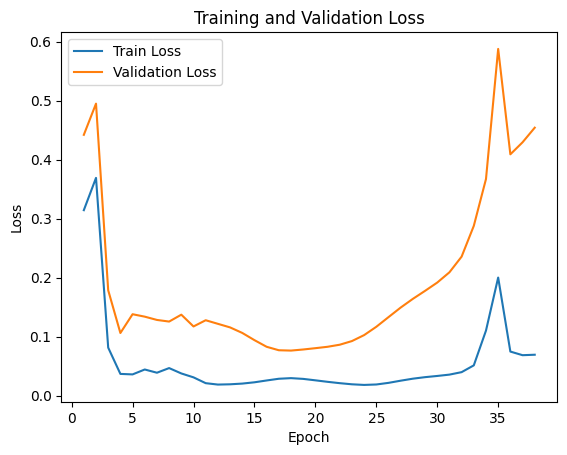

<Figure size 640x480 with 0 Axes>

In [61]:
# LSTM model 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers,dropout=0.3,batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)

        for layer in range(num_layers):
            for weight in self.lstm._all_weights[layer]:
                if "weight" in weight:
                    nn.init.xavier_uniform_(getattr(self.lstm,weight))
                if "bias" in weight:
                    nn.init.uniform_(getattr(self.lstm,weight))

    def forward(self, x):
        # 매 배치마다 hidden,cell state를 0으로 초기화하여 이전 배치 영향이 없도록 반영
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))
        out = self.fc(hidden_state[ -1])
        return out

input_size = 1
hidden_size = 256
num_layers = 1
num_epochs = 300
batch_size = 64
learning_rate = 0.01
early_stopping_epochs = 20
early_stop_counter = 0

for key in ['LG이노텍']:

    folder_name = f"{key} 결과"
    if not os.path.exists(os.path.join("./", folder_name)):
        os.makedirs(os.path.join("./", folder_name))

    # DataLoader로 로드
    train_dataset = TensorDataset(stock_dict_tmp[key]['X_train'], stock_dict_tmp[key]['y_train'])
    val_dataset = TensorDataset(stock_dict_tmp[key]['X_val'], stock_dict_tmp[key]['y_val'])
    test_dataset = TensorDataset(stock_dict_tmp[key]['X_test'], stock_dict_tmp[key]['y_test'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(f"현재 학습중인 종목 : {key}")
    best_loss = float('inf')
    train_loss_list = []
    val_loss_list = []
    # train
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_train_batch)
            loss = criterion(outputs, y_train_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = np.sqrt(train_loss / len(train_loader))
        train_loss_list.append(train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')

        # validation
        model.eval()
        valid_loss = 0.0
        predictions = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                output = model(X_val_batch)
                if len(output) == 1:
                    predictions.append(output.squeeze().tolist())
                else:
                    predictions.extend(output.squeeze().tolist())
                loss = criterion(output, y_val_batch)
                valid_loss += loss.item()
            valid_loss = np.sqrt(valid_loss / len(val_loader))
            val_loss_list.append(valid_loss)
        print(f'Validation Loss: {valid_loss:.4f}', "\n")

        # early stopping 적용
        if valid_loss > best_loss:
            early_stop_counter += 1
        else:
            best_loss = valid_loss
            early_stop_counter = 0

        if early_stop_counter >= early_stopping_epochs:
            print("Early Stop")
            torch.save(model, f'./{key} 결과/best_model.pt')
            break

    # loss graph
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, len(train_loss_list) + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    plt.savefig(f'./{key} 결과/loss_graph.png')

    # train/validation/test set에 대한 예측 결과 및 scaler 저장
    def get_predictions(loader):
        prediction = []
        true = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                outputs = model(X_batch)
                if len(outputs) == 1:
                    prediction.append(outputs.squeeze().tolist())
                else:
                    prediction.extend(outputs.squeeze().tolist())
                if len(y_batch) == 1:
                    true.append(y_batch.squeeze().tolist())
                else:
                    true.extend(y_batch.squeeze().tolist())
        return np.array(prediction).reshape(-1,1), np.array(true).reshape(-1,1)

    train_predict, train_labels = get_predictions(train_loader)
    val_predict, val_labels = get_predictions(val_loader)
    test_predict, test_labels = get_predictions(test_loader)

    train_result = pd.DataFrame()
    train_result['날짜'] = stock_dict_tmp[key]['train_date']
    train_result['실제 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(train_labels)
    train_result['예측 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(train_predict)
    val_result = pd.DataFrame()
    val_result['날짜'] = stock_dict_tmp[key]['val_date']
    val_result['실제 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(val_labels)
    val_result['예측 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(val_predict)
    test_result = pd.DataFrame()
    test_result['날짜'] = stock_dict_tmp[key]['test_date']
    test_result['실제 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(test_labels)
    test_result['예측 종가'] = stock_dict_tmp[key]['scaler'].inverse_transform(test_predict)

    train_result.to_csv(f'./{key} 결과/train_result.csv',index=False)
    val_result.to_csv(f'./{key} 결과/val_result.csv',index=False)
    test_result.to_csv(f'./{key} 결과/test_result.csv',index=False)
    pickle.dump(stock_dict_tmp[key]['scaler'], open(f'./{key} 결과/scaler.pickle', mode='wb'))
    pickle.dump(stock_dict_tmp[key], open(f'./{key} 결과/total_dict.pickle', mode='wb'))

In [44]:
stock_dict_tmp[key]['scaler'].inverse_transform(train_predict)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.